In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# read words 
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'daisuke']

In [7]:
len(words)

32034

In [8]:
# build the vocab of chars and mapping to/from int
chars = sorted(list(set(''.join(words))))
stoi = {ch: i + 1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
print(itos, len(chars))

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 26


In [43]:
block_size = 3 
def build_dataset(words):

    X_input, Y_label = [], []
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X_input.append(context)
            Y_label.append(ix)
            context = context[1:] + [ix] # crop and append

    X_input = torch.tensor(X_input, dtype=torch.int64)
    Y_label = torch.tensor(Y_label, dtype=torch.int64)
    print(X_input.shape, Y_label.shape)
    return X_input, Y_label

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182540, 3]) torch.Size([182540])
torch.Size([22936, 3]) torch.Size([22936])
torch.Size([22678, 3]) torch.Size([22678])


In [123]:
# MLP revised 
n_emb = 10
hidden_layer = 200
vocab_size = len(chars) + 1

g = torch.Generator().manual_seed(214483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, hidden_layer), generator=g) * 5/3 / (n_emb * block_size ** 0.5) # * 0.2
b1 = torch.randn((hidden_layer,), generator=g) * 0.01
W2 = torch.randn((hidden_layer, vocab_size), generator=g) * 0.01 # smaller weights, avoid 0
b2 = torch.randn((vocab_size,), generator=g) * 0

# batch norm parameters
bngain = torch.ones((1, hidden_layer))
bnbias = torch.zeros((1, hidden_layer))

bnmean_running = torch.zeros((1, hidden_layer))
bnstd_running = torch.ones((1, hidden_layer))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

total_param_size = sum(p.nelement() for p in parameters) # the number of parameters
print(total_param_size)
for p in parameters:
    p.requires_grad = True

12297


In [95]:
(torch.randn(10000) * (5/3) ** n_emb.blc).std()

tensor(0.1974)

tensor(0.0139) tensor(0.9960)
tensor(0.0010) tensor(0.9862)


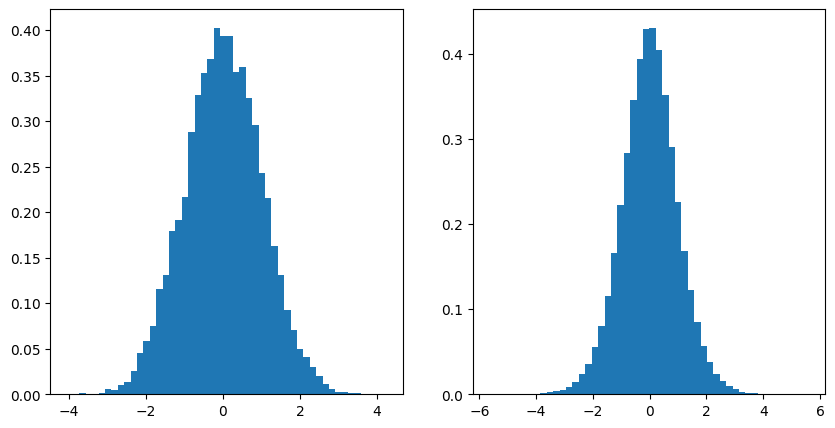

In [97]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 ** 0.5 # 重さをnの平方根で割ると、stdが1になりガウシアン分布の形が保たれる
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [135]:
batch_size = 32
lri = []
lossi = []
stepi = []
max_steps = 200000
epi = 1E-5

In [136]:
for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch of X and Y

    # forward pass
    emb = C[Xtr[ix]] # embedding the characters into vectors
    emb_cat = emb.view(-1, n_emb * block_size) # concatenate the vectors
    h_preactive = emb_cat @ W1 + # b1 # pre-activation of the hidden layer, b1 is not used but instead bnbias replaces the role

    # batch norm
    bn_mean = h_preactive.mean(0, keepdim=True)
    bn_std = h_preactive.std(0, keepdim=True)
    h_preactive = ((h_preactive - bn_mean) / (bn_std + epi)) * bngain + bnbias
    with torch.no_grad():
        bnmean_running = 0.99 * bnmean_running + 0.01 * bn_mean
        bnstd_running = 0.99 * bnstd_running + 0.01 * bn_std    
    
    h = torch.tanh(h_preactive) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # tracking stats
    # lri.append(lrp[i])
    if i % 10000 == 0:
        print(f"{i:7d}: {max_steps:7d} {loss.item():.4f}")
    lossi.append(loss.log10().item())

    # break

print(loss.item())

      0:  200000 1.9694
  10000:  200000 2.0529
  20000:  200000 1.8707
  30000:  200000 2.2392
  40000:  200000 2.0407
  50000:  200000 2.3224
  60000:  200000 2.1862
  70000:  200000 2.2225
  80000:  200000 2.2153
  90000:  200000 2.1721
 100000:  200000 2.4721
 110000:  200000 2.2088
 120000:  200000 2.1112
 130000:  200000 1.4319
 140000:  200000 1.8251
 150000:  200000 1.8323
 160000:  200000 1.7650
 170000:  200000 2.0303
 180000:  200000 2.0944
 190000:  200000 1.7696
1.9019019603729248


In [46]:
logits[0]

tensor([ 2.8820, -0.2483, -0.6292, -0.4638,  0.1082,  0.9481, -1.9411, -2.6668,
         2.1363,  3.2114, -0.7867, -0.1766,  0.0734, -0.1002,  5.2357, -2.2333,
        -1.8694, -4.0000, -0.1629,  1.5779,  0.9961,  1.6468,  0.4555, -0.7508,
        -4.7601,  2.8356, -0.8609], grad_fn=<SelectBackward0>)

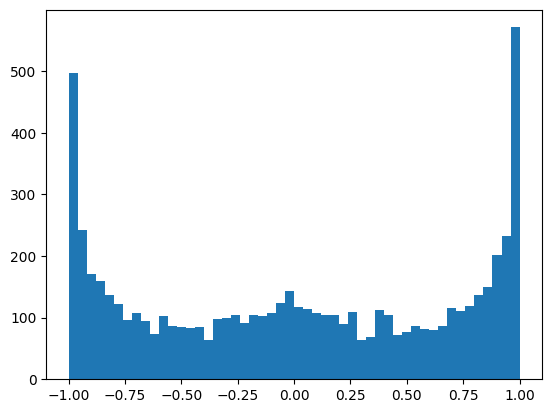

In [137]:
plt.hist(h.view(-1).tolist(), 50);

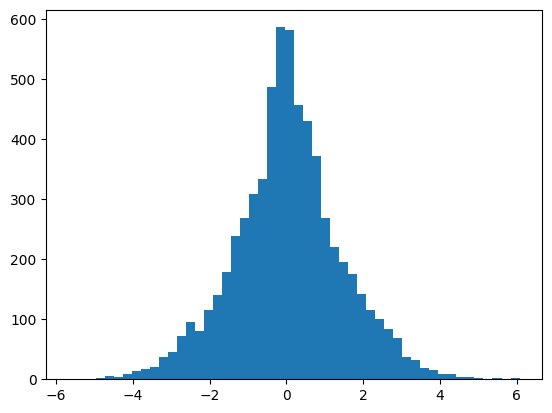

In [117]:
plt.hist(h_preactive.view(-1).tolist(), 50);

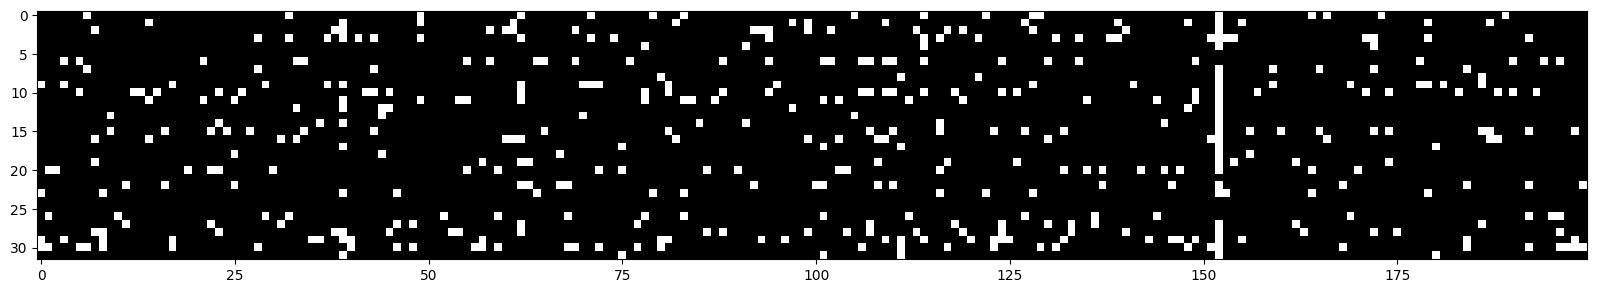

In [118]:
# tensorの中身を見る、bool で表示され 白黒で表示される。白 = True, 黒 = False
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation="nearest")

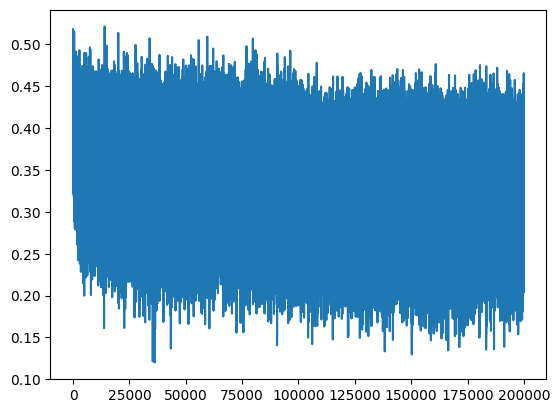

In [119]:
plt.plot(lossi) # loss over time, 初期値を調整するとhockey stickのようにならなくなる

In [33]:
# example issue 
logits = torch.tensor([ 1.0, 1.0, 1.0, 1.0]) # 全ての値が同じならlossはsoftmaxのおかげでそんなに悪くならない
# logits = torch.randn(4) * 100
prob = F.softmax(logits, dim=0)
loss = - prob[2].log()
prob, logits, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor([1., 1., 1., 1.]),
 tensor(1.3863))

In [126]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through the network
    emb = C[Xtr] # embedding the characters into vectors
    emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
    h_preactive = emb_cat @ W1 + b1 # pre-activation of the hidden layer

    # measure hte mean and std over the entire training set
    bnmean = h_preactive.mean(0, keepdim=True)
    bnstd = h_preactive.std(0, keepdim=True)

In [132]:
bnstd

tensor([[2.1174, 1.9980, 1.5973, 2.0178, 1.7887, 1.5723, 2.1611, 2.0278, 2.0546,
         1.8010, 2.0093, 1.9621, 2.0329, 2.3592, 1.8739, 1.6948, 2.2530, 1.6881,
         1.6506, 1.8264, 1.7089, 2.0523, 1.6050, 2.0380, 1.9370, 2.7159, 1.9671,
         1.9441, 1.8673, 1.9799, 1.8321, 1.8466, 1.8646, 1.9801, 1.6464, 2.0063,
         1.8456, 2.0174, 1.9978, 2.0200, 1.5639, 2.0733, 1.8241, 2.0283, 2.1156,
         1.8209, 2.0095, 2.2783, 1.5603, 1.7408, 2.0808, 1.7978, 1.8802, 1.9854,
         2.0398, 1.4997, 1.8516, 1.8237, 1.9361, 1.9099, 1.9317, 2.1783, 1.8014,
         1.9764, 1.8087, 1.8410, 1.5525, 1.9296, 2.0513, 2.1554, 1.8408, 1.9163,
         1.8795, 1.6670, 1.7629, 2.1518, 1.9502, 1.9978, 1.7506, 1.8179, 1.8851,
         1.7533, 1.8765, 2.2958, 1.7026, 1.8420, 1.5821, 1.5817, 1.7264, 1.7132,
         2.4305, 1.7129, 1.4678, 1.8061, 2.0721, 2.0951, 1.8738, 1.7851, 1.7347,
         1.8515, 1.0404, 2.2340, 1.8339, 1.9875, 1.6352, 1.6345, 2.0166, 1.7463,
         1.7337, 1.8756, 2.0

In [133]:
bnstd_running

tensor([[2.1115, 1.9807, 1.5834, 1.9857, 1.7626, 1.5534, 2.1069, 2.0040, 2.0512,
         1.7642, 1.9702, 1.9398, 2.0025, 2.3201, 1.8682, 1.7001, 2.2271, 1.6586,
         1.6077, 1.7952, 1.6870, 2.0138, 1.5703, 2.0211, 1.9136, 2.6759, 1.9436,
         1.8986, 1.8400, 1.9441, 1.8365, 1.8070, 1.8386, 1.9526, 1.6356, 1.9941,
         1.8425, 1.9727, 1.9843, 2.0181, 1.5564, 2.0284, 1.8135, 1.9722, 2.0882,
         1.7913, 1.9570, 2.2647, 1.5351, 1.7302, 2.0590, 1.7515, 1.8598, 1.9815,
         2.0318, 1.4962, 1.8422, 1.8085, 1.9374, 1.8833, 1.9110, 2.1309, 1.7946,
         1.9292, 1.8003, 1.8189, 1.5373, 1.8953, 2.0142, 2.0735, 1.8063, 1.8824,
         1.8451, 1.6446, 1.7666, 2.1102, 1.9005, 2.0175, 1.7463, 1.7974, 1.8488,
         1.7565, 1.8272, 2.2545, 1.6561, 1.8381, 1.5308, 1.5705, 1.7186, 1.7098,
         2.3879, 1.7004, 1.4412, 1.7837, 2.0535, 2.0741, 1.8462, 1.7374, 1.7003,
         1.7965, 1.0392, 2.1526, 1.8162, 1.9552, 1.6065, 1.6027, 1.9823, 1.7249,
         1.7175, 1.8679, 2.0

In [139]:
@torch.no_grad() # no need to track gradients, evaluating alone makes it faster
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1) # concatenate into (batch_size, n_emb * block_size)
    h_preactive = emb_cat @ W1 + b1 # N x hidden_layer
    # h_preactive = ((h_preactive - h_preactive.mean(0, keepdim=True)) / h_preactive.std(0, keepdim=True)) * bngain + bnbias
    # h_preactive = ((h_preactive - bnmean) / bnstd) * bngain + bnbias
    h_preactive = ((h_preactive - bnmean_running) / (bnstd_running + epi)) * bngain + bnbias
    h = torch.tanh(h_preactive) # N x hidden_layer
    logits = h @ W2 + b2 # N, vocab_size
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.4f}")

split_loss('train')
split_loss('val')

train loss: 2.0451
val loss: 2.1071


In [108]:
# sample from the model
g = torch.Generator().manual_seed(214483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # start with all ... (zeros)
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context and append the new char
        context = context[1:] + [ix]
        out.append(ix)
        # if we hit the end of the word(special token), stop
        if ix == 0:
            break

    print("".join(itos[i] for i in out)) # decord and print the word

jah.
kyme.
yer.
torricson.
nicolli.
kashe.
hawnan.
dilanna.
kamorre.
percerestianel.
leonia.
had.
kaime.
pensley.
railen.
colbi.
ava.
ahlisra.
chrionin.
eylina.


In [ ]:
# summary + pytorchfying the code

In [ ]:
# training a deeper network
# the classes we create here at the same API as nn.Module in Pytorch

In [167]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNormId:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running momentum uddate)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # training mode
            x_mean = x.mean(0, keepdim=True) # batch mean
            x_var = x.var(0, keepdim=True) # batch variance
        else:
            # evaluation mode
            x_mean = self.running_mean
            x_var = self.running_var
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta

        # update buffers
        if self.training:
            self.running_mean = self.momentum * x_mean + (1 - self.momentum) * self.running_mean
            self.running_var = self.momentum * x_var + (1 - self.momentum) * self.running_var

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    
        def __call__(self, x):
            self.out = torch.tanh(x)
            return self.out
    
        def parameters(self):
            return []

n_emb = 10 # the dimentionality of the embedding vectors 
n_hidden = 100 # the number of hidden units
g = torch.Generator().manual_seed(214483647) # the random number generator

C = torch.randn((vocab_size, n_emb), generator=g) # the embedding matrix
layers = [
    Linear(n_emb * block_size, n_hidden, bias=False), BatchNormId(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNormId(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNormId(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNormId(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNormId(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNormId(vocab_size),
]

with torch.no_grad():
    # last layer make less confident predictions
    layers[-1].gamma *= 0.1
    # all other layers apply gain
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 # 5/3, batch normを使わないときの初期値gain

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [169]:
batch_size = 32
lri = []
lossi = []
stepi = []
max_steps = 200000
ud = []

for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch of X and Y

    # forward pass
    emb = C[Xb] # embedding the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # tracking stats
    # lri.append(lrp[i])
    if i % 10000 == 0:
        print(f"{i:7d}: {max_steps:7d} {loss.item():.4f}")
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters])
    # if i > 1000:
        # break # after debug: would take out this line

print(loss.item())

      0:  200000 3.3252
  10000:  200000 2.5782
  20000:  200000 2.0761
  30000:  200000 2.3685
  40000:  200000 2.3260
  50000:  200000 2.0337
  60000:  200000 2.2260
  70000:  200000 2.2059
  80000:  200000 2.3982
  90000:  200000 2.0682
 100000:  200000 2.3431
 110000:  200000 2.0283
 120000:  200000 1.8699
 130000:  200000 2.0879
 140000:  200000 2.0886
 150000:  200000 1.9882
 160000:  200000 1.5341
 170000:  200000 2.5013
 180000:  200000 2.4795
 190000:  200000 1.7587
2.183626174926758


layer 2(      Tanh): mean +0.00381, std 0.71, saturated: 8.16%
layer 5(      Tanh): mean -0.00480, std 0.74, saturated: 8.78%
layer 8(      Tanh): mean +0.00986, std 0.77, saturated: 8.78%
layer 11(      Tanh): mean -0.01345, std 0.77, saturated: 8.09%
layer 14(      Tanh): mean -0.00012, std 0.78, saturated: 8.25%


Text(0.5, 1.0, 'active distribution')

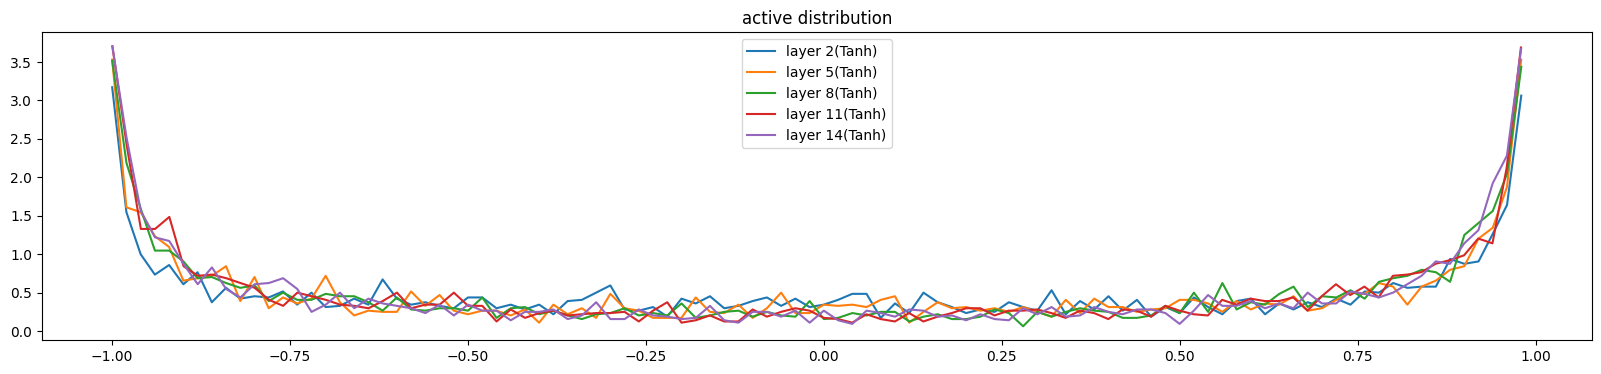

In [170]:
# visualize histograms 
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d(%10s): mean %+.5f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.99).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i}({layer.__class__.__name__})")
plt.legend(legends);
plt.title("active distribution")

layer 2(      Tanh): mean +0.00000, std 4.552332e-03
layer 5(      Tanh): mean -0.00000, std 4.082300e-03
layer 8(      Tanh): mean -0.00000, std 3.928237e-03
layer 11(      Tanh): mean +0.00000, std 3.773420e-03
layer 14(      Tanh): mean +0.00000, std 3.752648e-03


Text(0.5, 1.0, 'gradient distribution')

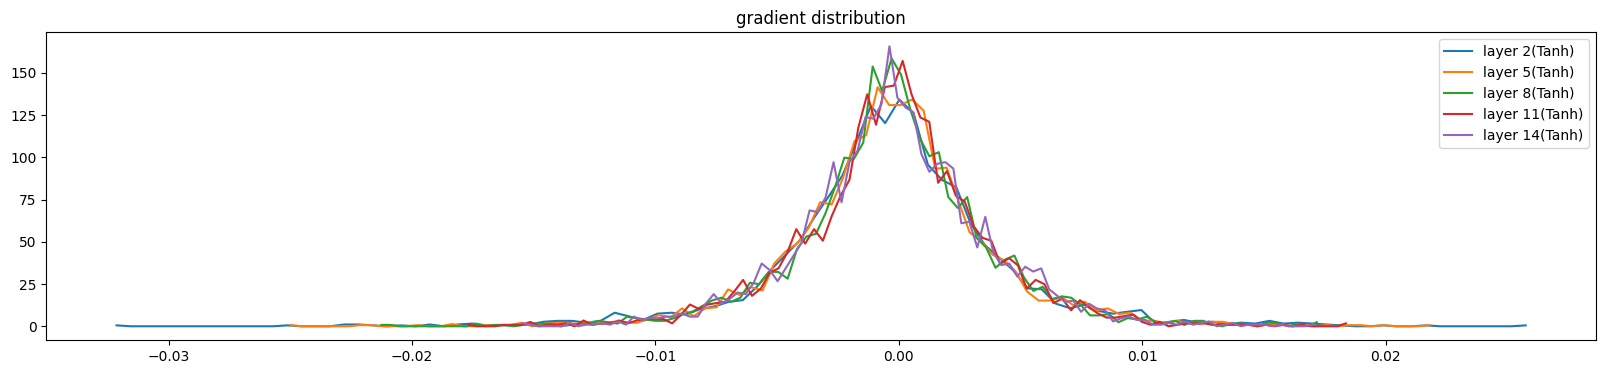

In [171]:
# visualize histrograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d(%10s): mean %+.5f, std %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i}({layer.__class__.__name__})")
plt.legend(legends);
plt.title("gradient distribution")

weight   (27, 10) | mean +0.000000, std 1.940871e-02 | grad:data ratio 1.776549e-02
weight  (30, 100) | mean +0.000067, std 1.213228e-02 | grad:data ratio 3.398114e-02
weight (100, 100) | mean -0.000009, std 7.638212e-03 | grad:data ratio 3.562351e-02
weight (100, 100) | mean -0.000012, std 7.241284e-03 | grad:data ratio 3.445617e-02
weight (100, 100) | mean +0.000055, std 6.769038e-03 | grad:data ratio 3.375276e-02
weight (100, 100) | mean -0.000004, std 6.099169e-03 | grad:data ratio 3.244275e-02
weight  (100, 27) | mean +0.000019, std 8.849276e-03 | grad:data ratio 2.886421e-02


Text(0.5, 1.0, 'weight gradient distribution')

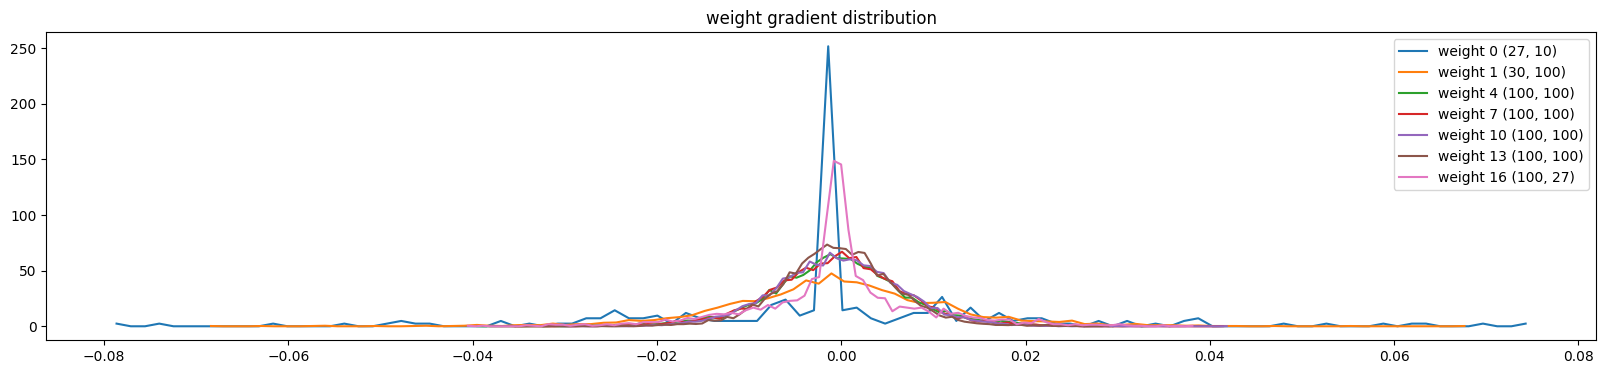

In [172]:
# visualize histrograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print("weight %10s | mean %+f, std %e | grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"weight {i} {tuple(p.shape)}")
plt.legend(legends);
plt.title("weight gradient distribution")

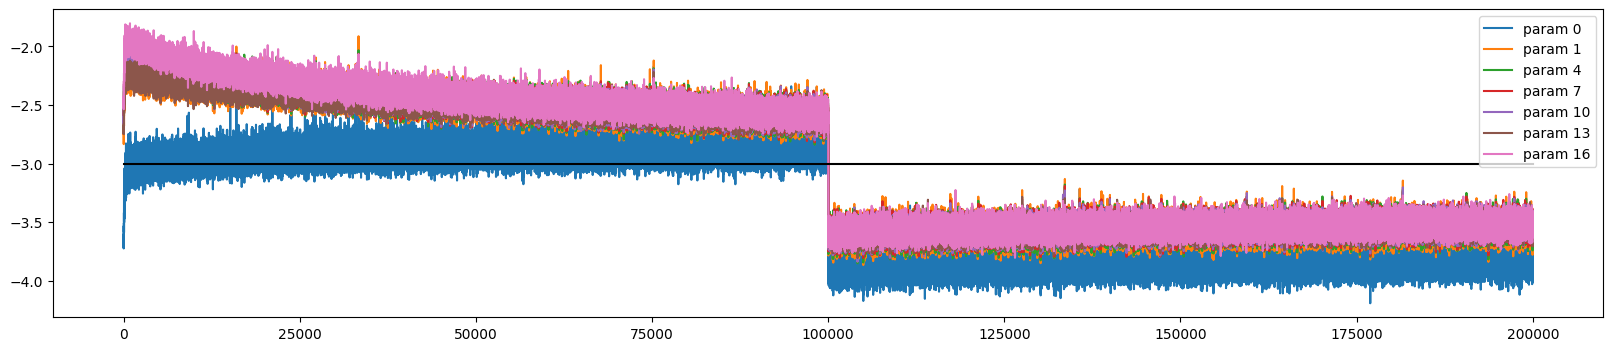

In [173]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k") # these ratios should be -1e-3, indecate on the plot
plt.legend(legends);

In [175]:
@torch.no_grad() # no need to track gradients, evaluating alone makes it faster
def split_loss(split):
    x, y = {
        'traing': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1) # concatenate into (batch_size, n_emb * block_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print (f"{split} loss: {loss.item():.4f}")

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('traing')
split_loss('val')

traing loss: 2.0081
val loss: 2.0861


In [176]:
# sample from the model
g = torch.Generator().manual_seed(214483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # start with all ... (zeros)
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x # (1, n_vocab)
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context and append the new char
        context = context[1:] + [ix]
        out.append(ix)
        # if we hit the end of the word(special token), stop
        if ix == 0:
            break

    print("".join(itos[i] for i in out)) # decord and print the word

jah.
kymonie.
lilan.
fred.
nicolli.
kasee.
hawn.
drick.
namorcio.
regan.
cariel.
anel.
leonia.
has.
kaime.
pensley.
railen.
colba.
alphant.
sril.
